
#Topic 2: Remote Sensing and flux analysis

Tutorial created by:

D. Durden ddurden@battelleecology.org

N. Falco nicolafalco@lbl.gov

S. Metzger smetzger@atmofacts.com

*** Copyright Notice ***

2024 Workshop - Remote Sensing and Fluxes Upscaling for Real-world Impact - Tutorial Copyright (c) 2025, The Regents of the University of California, through Lawrence Berkeley National Laboratory (subject to receipt of any required approvals from the U.S. Dept. of Energy), Battelle, through National Ecological Observatory Network (NEON), and AtmoFacts. All rights reserved.

This software is available under the GNU Affero General Public License
(“AGPL”) v3. If you have questions about your rights to use or distribute this
software, please contact Berkeley Lab's Intellectual Property Office at
 IPO@lbl.gov.

NOTICE.  This Software was developed under funding from the U.S. Department
of Energy and the U.S. Government consequently retains certain rights.  As
such, the U.S. Government has been granted for itself and others acting on
its behalf a paid-up, nonexclusive, irrevocable, worldwide license in the
Software to reproduce, distribute copies to the public, prepare derivative
works, and perform publicly and display publicly, and to permit others to do so.

#First step: make a copy of the notebook.

File -> save a copy on Drive -> open that file (located in the "Colabl notebooks" folder in "My Drive")

##PART 1. Derive model from timeseries

We mount Google drive, where the data is stored. We then initialize the external library to execute R code in the python environment.

NOTE: the Google account used to access Google Drive and this notebook and the account for Google Earth Engine have to be the same one.

In [ ]:
# Mount drive files

from google.colab import drive
drive.mount('/content/drive/')

%load_ext rpy2.ipython


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Install and load all of our R dependencies for the workflow.

In [ ]:
%%R

#Install amerifluxr
if(!require(remotes)){install.packages("remotes")}
remotes::install_github("chuhousen/amerifluxr")

#Call the R HDF5 Library
packReq <- c('lubridate',"terra", "amerifluxr", "stringr", "R.utils")

#Install and load all required packages
lapply(packReq, function(x) {
#  print(x)
  if(require(x, character.only = TRUE) == FALSE) {
    install.packages(x)
    library(x, character.only = TRUE)
  }})


These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

 1: All                                  
 2: CRAN packages only                   
 3: None                                 
 4: cli        (3.6.2  -> 3.6.3  ) [CRAN]
 5: rlang      (1.1.3  -> 1.1.4  ) [CRAN]
 6: crayon     (1.5.2  -> 1.5.3  ) [CRAN]
 7: fastmap    (1.1.1  -> 1.2.0  ) [CRAN]
 8: munsell    (0.5.0  -> 0.5.1  ) [CRAN]
 9: farver     (2.1.1  -> 2.1.2  ) [CRAN]
10: isoband    (0.2.6  -> 0.2.7  ) [CRAN]
11: gtable     (0.3.4  -> 0.3.5  ) [CRAN]
12: ggplot2    (3.4.4  -> 3.5.1  ) [CRAN]
13: ps         (1.7.6  -> 1.7.7  ) [CRAN]
14: processx   (3.8.3  -> 3.8.4  ) [CRAN]
15: callr      (3.7.3  -> 3.7.6  ) [CRAN]
16: fs         (1.6.3  -> 1.6.4  ) [CRAN]
17: sass       (0.4.8  -> 0.4.9  ) [CRAN]
18: cachem     (1.0.8  -> 1.1.0  ) [CRAN]
19: tinytex    (0.49   -> 0.51   ) [CRAN]
20: bslib      (0.6.1  -> 0.7.0  ) [CRAN]
21: xfun       (0.41   -> 0.45   )


(as ‘lib’ is unspecified)














































































































































	‘/tmp/RtmpmcGUoi/downloaded_packages’



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpmcGUoi/remotes22433d4474d/chuhousen-amerifluxr-97d7ffc/DESCRIPTION’ ... OK
* preparing ‘amerifluxr’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘amerifluxr_1.0.0.tar.gz’



(as ‘lib’ is unspecified)


Attaching package: ‘lubridate’



    date, intersect, setdiff, union



(as ‘lib’ is unspecified)







	‘/tmp/RtmpmcGUoi/downloaded_packages’



(as ‘lib’ is unspecified)





























	‘/tmp/RtmpmcGUoi/downloaded_packages’



(as ‘lib’ is unspecified)



















	‘/tmp/RtmpmcGUoi/downloaded_packages’





Attaching package: ‘R.oo’



    throw



    extend, trim



    getClasses, getMethods



    attach, detach, load, save



Attaching package: ‘R.utils’



    draw, extract, resample, unwrap, wrap



    timestamp



    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings




[[1]]
NULL

[[2]]
 [1] "terra"     "lubridate" "remotes"   "tools"     "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "amerifluxr" "terra"      "lubridate"  "remotes"    "tools"     
 [6] "stats"      "graphics"   "grDevices"  "utils"      "datasets"  
[11] "methods"    "base"      

[[4]]
NULL

[[5]]
 [1] "R.utils"     "R.oo"        "R.methodsS3" "stringr"     "amerifluxr" 
 [6] "terra"       "lubridate"   "remotes"     "tools"       "stats"      
[11] "graphics"    "grDevices"   "utils"       "datasets"    "methods"    
[16] "base"       



We will download the FLUXNET data product for the US-xUN (NEON site code: UNDE) site using the [amerifluxr package](https://cran.r-project.org/web/packages/amerifluxr/index.html). The download package will include several termporal aggregations, we will read in the weekly aggregated product as it aligns well with the temporal resolution of the satellite imagery.

The code will shows warnings and ask if you want to update the packages. The code will ask inputs from you. No need to do update packages

In [ ]:
%%R

#Download directory
DirDnld <- tempdir()
DirExtr <- paste0(DirDnld,"/DirExtr")
#Check if directory exists and create if not
if(!dir.exists(DirExtr)) dir.create(DirExtr, recursive = TRUE)

#Type of data
DataType <- "FULLSET"
#Time aggregation
TimeAgg <- c("HH","DD","WW","MM","YY")[3]
#NEON site
Site <- "US-xUN"

#Get file via amerifluxr
fileInp <- amerifluxr::amf_download_fluxnet(
  user_id = "ddurden",
  user_email = "daviddurden27@gmail.com",
  site_id = Site,
  data_product = "FLUXNET",
  data_variant = DataType,
  agree_policy = TRUE,
  intended_use = "other",
  intended_use_text = "flux scaling workshop",
  out_dir = DirDnld)

#Unzip file
sapply(fileInp, function(x) utils::unzip(zipfile = x, exdir = DirExtr))


#Read in file
FileInp <- list.files(DirExtr, pattern = paste0(DataType,"_",TimeAgg), full.names = TRUE)
#Name data frame by site
names(FileInp) <- Site
dfDataFlux <- read.csv(FileInp)

Data use guidelines for AmeriFlux CC-BY-4.0 Data Policy:

(1) Data user is free to Share (copy and redistribute the material in any medium or format) and/or Adapt (remix, transform, and build upon the material) for any purpose.
(2) Provide a citation to each site data product that includes the data-product DOI and/or recommended publication.
(3) Acknowledge funding for supporting AmeriFlux data portal: U.S. Department of Energy Office of Science.



Now, we will do some data cleaning by converting the missing data value (-9999) to NaN and creating a new date in middle of the weekly window to help align the weekly aggregated flux data with the remote sensing data.

In [ ]:
%%R
#Replace -9999 with NaN
dfDataFlux <- replace(dfDataFlux, dfDataFlux == -9999, NaN)

#Convert data to allow plotting
DateConv <- c("HH" = "ymdHM","DD" = "ymd","WW" = "ymd","MM" = "ym","YY" = "y")
dfDataFlux$TIMESTAMP <- lubridate::parse_date_time(dfDataFlux$TIMESTAMP_START, orders = DateConv[TimeAgg]) + lubridate::days(3)
#look at data
names(dfDataFlux)


  [1] "TIMESTAMP_START"                "TIMESTAMP_END"                 
  [3] "TA_F_MDS"                       "TA_F_MDS_QC"                   
  [5] "TA_F_MDS_NIGHT"                 "TA_F_MDS_NIGHT_SD"             
  [7] "TA_F_MDS_NIGHT_QC"              "TA_F_MDS_DAY"                  
  [9] "TA_F_MDS_DAY_SD"                "TA_F_MDS_DAY_QC"               
 [11] "TA_ERA"                         "TA_ERA_NIGHT"                  
 [13] "TA_ERA_NIGHT_SD"                "TA_ERA_DAY"                    
 [15] "TA_ERA_DAY_SD"                  "TA_F"                          
 [17] "TA_F_QC"                        "TA_F_NIGHT"                    
 [19] "TA_F_NIGHT_SD"                  "TA_F_NIGHT_QC"                 
 [21] "TA_F_DAY"                       "TA_F_DAY_SD"                   
 [23] "TA_F_DAY_QC"                    "SW_IN_POT"                     
 [25] "SW_IN_F_MDS"                    "SW_IN_F_MDS_QC"                
 [27] "SW_IN_ERA"                      "SW_IN_F"                

Let's read in the Landsat and MODIS timeseries data from our tower pixel out of the Google drive. We will then determine the weekly aggregated flux timestamp that is closest to each satellite image capture. We will determine the closest time index for the flux data and then filter the flux data for time and Net Ecosystem Exchange (NEE) and combine with remote sensing data into a data.frame for both Landsat and MODIS. We will be using the NEE_VUT_REF, where VUT stands for Variable Ustar Threshold and reference selected on the basis of the model efficiency (MEF). The MEF analysis is repeated for each time aggregation (see [Pastorello et al., 2020](https://www.nature.com/articles/s41597-020-0534-3)).

In [ ]:
%%R

# Option 1: Read the data saved in your Colab Notebooks folder during the data gathering
#dfLsat <- read.csv("/content/drive/MyDrive/Colab Notebooks/L8f_VI_poi_df_QA.csv")
#dfMlai <- read.csv("/content/drive/MyDrive/Colab Notebooks/MLAIf_poi_df_QA.csv")

# Option 2: Read the data from the the Workshop shared folder
dfLsat <- read.csv("/content/drive/Shareddrives/2024 Workshop - Remote Sensing and Fluxes Upscaling for Real-world Impact/Hands-on session/Topic1/Datasets/L8f_VI_poi_df_QA.csv")
dfMlai <- read.csv("/content/drive/Shareddrives/2024 Workshop - Remote Sensing and Fluxes Upscaling for Real-world Impact/Hands-on session/Topic1/Datasets/MLAIf_poi_df_QA.csv")

#Align the flux measurements with the Landsat RS data
idxFluxLsat <- sapply(1:nrow(dfLsat), function(x) {which.min(abs(difftime(dfLsat$datetime[x], dfDataFlux$TIMESTAMP)))})
idxFluxMlai <- sapply(1:nrow(dfMlai), function(x) {which.min(abs(difftime(dfMlai$datetime[x], dfDataFlux$TIMESTAMP)))})


dfFiltLsat <- cbind.data.frame(dfLsat, NEE = dfDataFlux[idxFluxLsat, "NEE_VUT_REF"])
dfFiltMlai <- cbind.data.frame(dfMlai, NEE = dfDataFlux[idxFluxMlai, "NEE_VUT_REF"])

head(dfFiltLsat)


          time                datetime      NDVI       EVI      NIRV QA_PIXEL
1 1.502556e+12 2017-08-12 16:46:17.927 0.8795497 0.6721546 0.3473408    21824
2 1.503334e+12 2017-08-21 16:40:09.569 0.8458461 0.7161927 0.3649445    21824
3 1.505321e+12 2017-09-13 16:46:22.160 0.8142399 0.5606496 0.2852302    21824
4 1.507481e+12 2017-10-08 16:40:21.299 0.4949958 0.2470805 0.1093384    21824
5 1.526834e+12 2018-05-20 16:39:01.828 0.8192626 0.5574369 0.2742379    21824
6 1.531587e+12 2018-07-14 16:45:25.696 0.9055732 0.7689373 0.4172610    21824
         NEE
1 -2.5995000
2 -3.6719800
3 -2.6388700
4  1.0148900
5  0.0953384
6 -4.9739700


Let's have a look at the data and how they compare to each other, we'll start with NDVI.


Call:
lm(formula = NEE ~ NDVI, data = dfFiltLsat)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6978 -0.9024 -0.1131  0.6320  2.9971 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)    5.005      1.745   2.867   0.0124 * 
NDVI          -9.360      2.288  -4.091   0.0011 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.711 on 14 degrees of freedom
Multiple R-squared:  0.5445,	Adjusted R-squared:  0.512 
F-statistic: 16.74 on 1 and 14 DF,  p-value: 0.001102



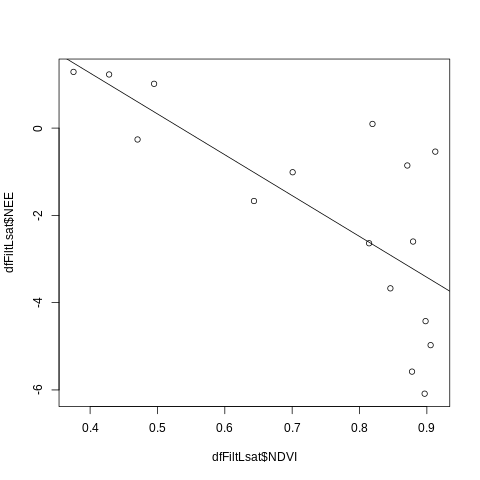

In [ ]:
%%R

#Scatterpolot of NDVI vs. NEE
plot(dfFiltLsat$NDVI, dfFiltLsat$NEE)
#Create a linear model
modlNDVI <- lm(NEE ~ NDVI, data = dfFiltLsat)
#Add model line to plot
abline(modlNDVI)
#Evaluate the summary statistics from the model
summary(modlNDVI)

We can do the same for the EVI, NIRV, and LAI.


Call:
lm(formula = NEE ~ EVI, data = dfFiltLsat)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.24277 -0.88606 -0.08791  0.32630  2.75475 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.833      1.044   2.714 0.016777 *  
EVI           -8.627      1.762  -4.897 0.000236 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.539 on 14 degrees of freedom
Multiple R-squared:  0.6313,	Adjusted R-squared:  0.605 
F-statistic: 23.98 on 1 and 14 DF,  p-value: 0.0002358



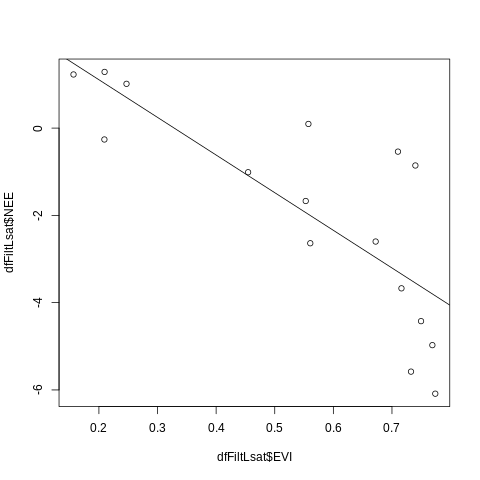

In [ ]:
%%R

#Plot and model EVI
plot(dfFiltLsat$EVI, dfFiltLsat$NEE)
modlEVI <- lm(NEE ~ EVI, data = dfFiltLsat)
abline(modlEVI)

#Output summary stats
summary(modlEVI)


Call:
lm(formula = NEE ~ NIRV, data = dfFiltLsat)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3091 -0.8072 -0.2063  0.4176  3.0751 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.0566     0.9488   2.168 0.047926 *  
NIRV        -14.2934     3.0959  -4.617 0.000399 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.596 on 14 degrees of freedom
Multiple R-squared:  0.6036,	Adjusted R-squared:  0.5753 
F-statistic: 21.32 on 1 and 14 DF,  p-value: 0.0003994



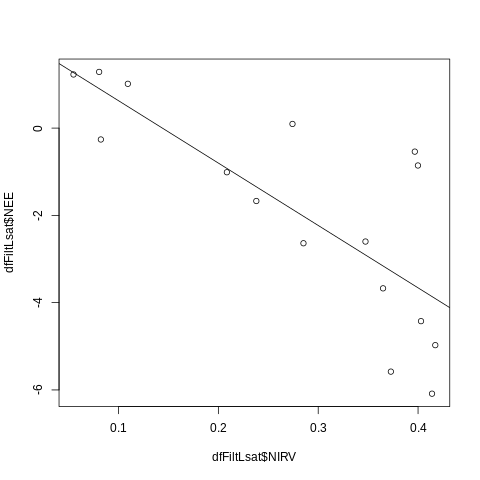

In [ ]:
%%R

#Plot and model NIRV
plot(dfFiltLsat$NIRV, dfFiltLsat$NEE)
modlNIRV <- lm(NEE ~ NIRV, data = dfFiltLsat)
abline(modlNIRV)

#Output summary stats
summary(modlNIRV)


Call:
lm(formula = NEE ~ Lai, data = dfFiltMlai)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8908 -0.5415  0.1858  0.8527  3.1566 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.114723   0.289725   3.848 0.000299 ***
Lai         -0.090782   0.008265 -10.984 8.56e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.46 on 58 degrees of freedom
Multiple R-squared:  0.6753,	Adjusted R-squared:  0.6697 
F-statistic: 120.6 on 1 and 58 DF,  p-value: 8.555e-16



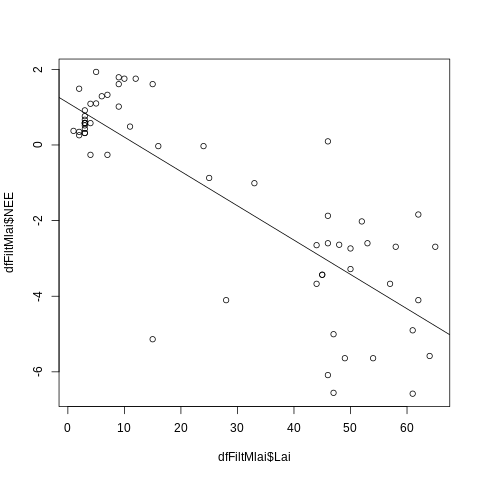

In [ ]:
%%R

#Plot and model LAI
plot(dfFiltMlai$Lai, dfFiltMlai$NEE)
modlLAI <- lm(NEE ~ Lai, data = dfFiltMlai)
abline(modlLAI)

#Output summary stats
summary(modlLAI)

Now, we want to determine the best the vegetation index that provides the best relationship with NEE. We can see that the MODIS LAI has the strongest R<sup>2</sup> relation. We can also use Akaike's ‘An Information Criterion’ to maximize the log-likelihood value when comparing fitted model objects.

In [ ]:
%%R

#"An Information Criterion"
AIC(modlNDVI, modlEVI, modlNIRV)

         df      AIC
modlNDVI  3 66.45258
modlEVI   3 63.06782
modlNIRV  3 64.23004


The lower the AIC value the better the fit, so we will use EVI from Landsat to predict our fluxes. We will also use MODIS LAI and compare the two maps at different spatial resolutions. We will start by reading in our raster data.

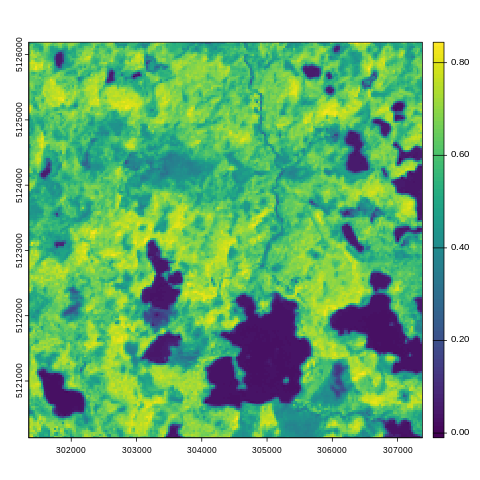

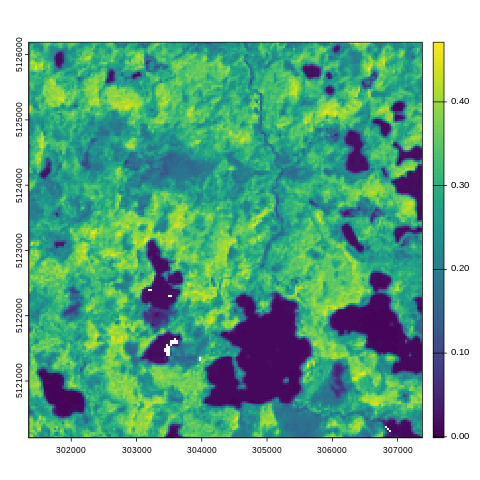

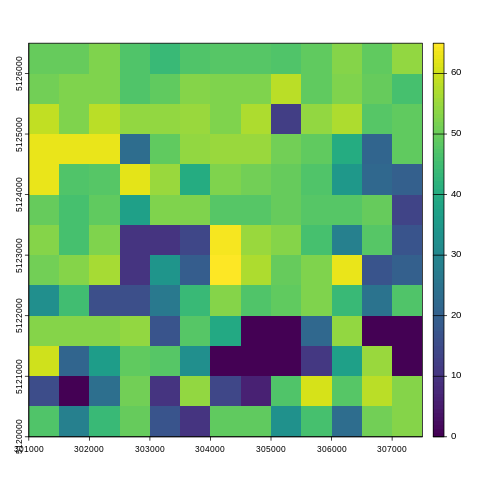

In [ ]:
%%R

#Read in Landsat and MODIS .tif data

# Option 1: Read the data from the the Workshop shared folder
rastLsat <- terra::rast("/content/drive/Shareddrives/2024 Workshop - Remote Sensing and Fluxes Upscaling for Real-world Impact/Hands-on session/Topic1/Datasets/Landsat8_VI_6km.tif")
rastMlai <- terra::rast("/content/drive/Shareddrives/2024 Workshop - Remote Sensing and Fluxes Upscaling for Real-world Impact/Hands-on session/Topic1/Datasets/MODIS_LAI_6km.tif")

# Option 2: Read the data saved in your Colab Notebooks folder during the data gathering
#rastLsat <- terra::rast("/content/drive/MyDrive/Colab Notebooks/Landsat8_VI_6km.tif")
#rastMlai <- terra::rast("/content/drive/MyDrive/Colab Notebooks/MODIS_LAI_6km.tif")

#Plot raster data
plot(rastLsat$EVI)
plot(rastMlai$Lai)

We can clearly see the additional detail observed at the 30 m resolution from Landsat will provide more realistic representation of the vegetation at our site. The coarser 250 m resolution of the MODIS LAI product definitely reduces the fidelity to which we can attribute fluxes to the landscape.

We will now apply our models for EVI and LAI to create predicted flux maps across our 6 x 6 km domain.

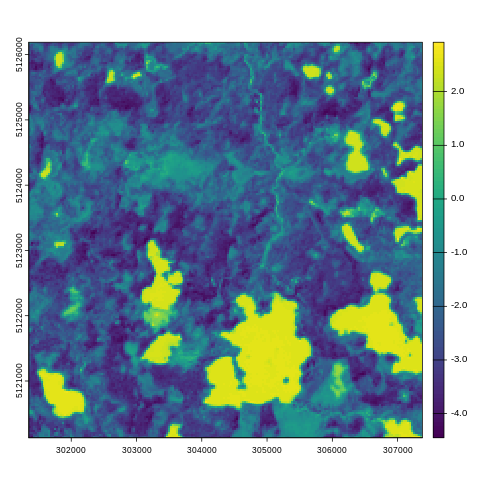

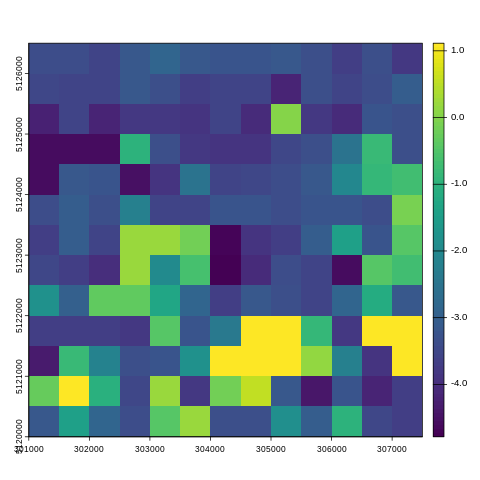

In [ ]:
%%R

#Predict flux values using the relationships to Landsat EVI and MODIS LAI
fluxEVI <- terra::predict(rastLsat$EVI, model = modlEVI, na.rm = T)
fluxLai <- terra::predict(rastMlai$Lai, model = modlLAI, na.rm = T)

#Plot resultant flux maps
plot(fluxEVI)
plot(fluxLai)

These predictions were made solely using temporal reslationships from a single satellite pixel where the US-xUN (UNDE) tower is located.The next tutorial will focus on extracting spatial relationships between these same remote sensing data products and flux maps.

### Pitfalls and challenges

1. Is our range of values valid?

In [ ]:
%%R

# let's check the EVI range or our input data for the regression
print(range(dfFiltLsat$EVI))

# now let's also check the range of EVI values in our EVI map
global(rastLsat$EVI, c("min", "max"), na.rm = TRUE)


[1] 0.1566701 0.7739186
            min       max
EVI -0.01016632 0.8441951


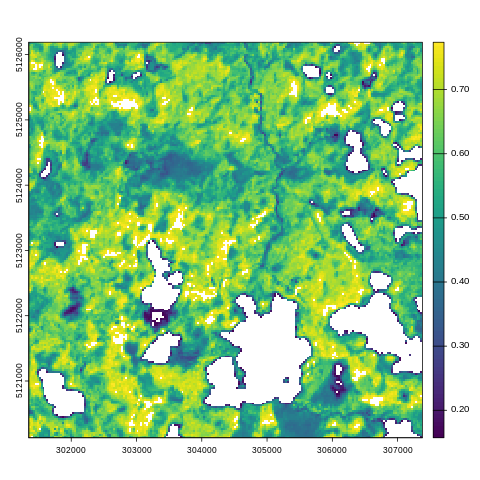

In [ ]:
%%R

# The EVI raster exceeds the training data range.
# Let's remove those values so our predictions remain valid within the range of our training data, and plot again
rastLsat$EVI <- ifel(rastLsat$EVI < min(dfFiltLsat$EVI) | rastLsat$EVI > max(dfFiltLsat$EVI), NA, rastLsat$EVI)
# rastMlai$Lai <- ifel(rastMlai$Lai < min(dfFiltMlai$Lai) | rastMlai$Lai > max(dfFiltMlai$Lai), NA, rastMlai$Lai)
plot(rastLsat$EVI)
# plot(rastMlai$Lai)

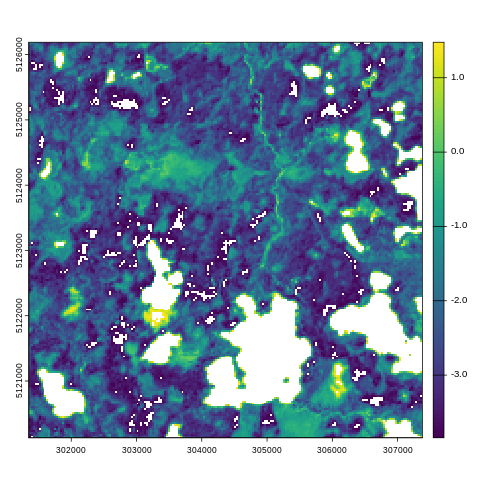

In [ ]:
%%R

#Let's also predict flux values again using the relationships to Landsat EVI and MODIS LAI
fluxEVI <- terra::predict(rastLsat$EVI, model = modlEVI, na.rm = T)
# fluxLai <- terra::predict(rastMlai$Lai, model = modlLAI, na.rm = T)

#Plot resultant flux maps
plot(fluxEVI)
# plot(fluxLai)

# note how alongside the EVI map, also the range of values for the flux map reduced from -4.5 ... +3 to -4 ... +1.5

2. Did our tower flux measurement consistenly represent the training pixel?

In [ ]:
%%R

# read in minute-resolution flux "air parcels"
kyd <- read.csv(file = "/content/drive/Shareddrives/2024 Workshop - Remote Sensing and Fluxes Upscaling for Real-world Impact/Hands-on session/Topic2/Datasets/US-xUN_20190729-20190806_get-to-know-your-flux-data.csv",
                na = "NA", stringsAsFactors = FALSE)

# check out the dataframe!
str(kyd)
# 'data.frame':	8613 obs. of  24 variables:
# $ record                : chr  "UTC201907290000" "UTC201907290000" ...
# $ NEE_VUT_REF           : num  2.86 2.86 2.86 2.86 2.86 ...
# $ NEE_CUT_REF           : num  2.86 2.86 2.86 2.86 2.86 ...
# $ data.fluxCo2.turb.flux: num  2.48 2.48 2.48 2.48 2.48 ...
# $ timeUtcDay            : num  210 210 210 210 210 ...
# $ response              : num  1.86 2.29 2.05 1.55 1.62 ...
# $ Evi                   : num  0.654 0.649 0.646 0.642 0.636 ...
# $ LSTnight              : num  293 293 293 293 293 ...
# $ LSTtrans              : num  287 287 287 287 287 ...
# $ LSTmute               : num  288 288 288 288 288 ...
# $ LSTday                : num  298 298 298 298 298 ...
# $ Wetlands              : num  0.506 0.546 0.552 0.554 0.55 ...
# $ Deciduous.forest      : num  0.483 0.439 0.432 0.429 0.43 ...
# $ Open.water            : num  0.000874 0.001731 0.001859 0.001646 ...
# $ Other.Forest          : num  0.000641 0.001024 0.001127 0.001221 ...
# $ Developed.land        : num  0.00935 0.01215 0.01314 0.01424 ...
# $ tempAir               : num  303 303 303 303 303 ...
# $ rtioMoleDryH2o        : num  0.0274 0.0274 0.0274 0.0274 0.0274 ...
# $ rtioMoleDryCo2        : num  0.000382 0.000382 0.000382 0.000383 ...
# $ SW_IN                 : num  13.1 13.1 13.1 13.1 13.1 13.1 13.1 ...
# $ zm_zi                 : num  0.0503 0.0503 0.0503 0.0503 0.0503 ...
# $ azi_cos               : num  0.223 0.226 0.229 0.232 0.235 ...
# $ azi_sin               : num  -0.975 -0.974 -0.973 -0.973 -0.972 ...
# $ azi_deg               : num  283 283 283 283 284 ...


'data.frame':	8613 obs. of  24 variables:
 $ record                : chr  "UTC201907290000" "UTC201907290000" "UTC201907290000" "UTC201907290000" ...
 $ NEE_VUT_REF           : num  2.86 2.86 2.86 2.86 2.86 ...
 $ NEE_CUT_REF           : num  2.86 2.86 2.86 2.86 2.86 ...
 $ data.fluxCo2.turb.flux: num  2.48 2.48 2.48 2.48 2.48 ...
 $ timeUtcDay            : num  210 210 210 210 210 ...
 $ response              : num  1.86 2.29 2.05 1.55 1.62 ...
 $ Evi                   : num  0.654 0.649 0.646 0.642 0.636 ...
 $ LSTnight              : num  293 293 293 293 293 ...
 $ LSTtrans              : num  287 287 287 287 287 ...
 $ LSTmute               : num  288 288 288 288 288 ...
 $ LSTday                : num  298 298 298 298 298 ...
 $ Wetlands              : num  0.506 0.546 0.552 0.554 0.55 ...
 $ Deciduous.forest      : num  0.483 0.439 0.432 0.429 0.43 ...
 $ Open.water            : num  0.000874 0.001731 0.001859 0.001646 0.001249 ...
 $ Other.Forest          : num  0.000641 0.001024

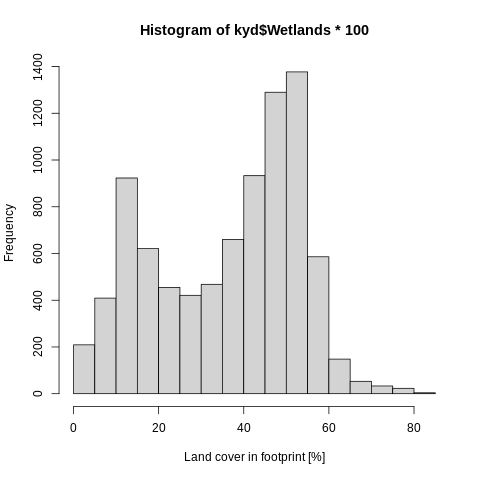

In [ ]:
%%R

# throughout the week, has the land cover sampled by the flux tower been homogeneous? normal distributed?
# feel free to explore other land covers, land surface temperature (LST), enhanced vegetation index (EVI)!
hist(kyd$Wetlands * 100, xlab = "Land cover in footprint [%]")


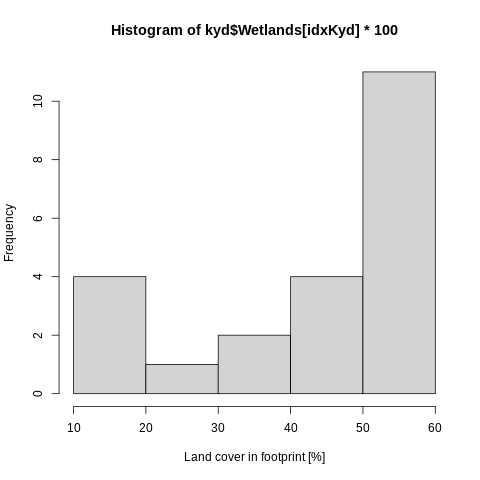

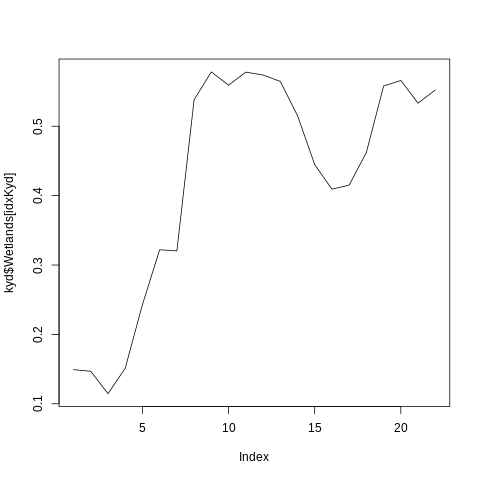

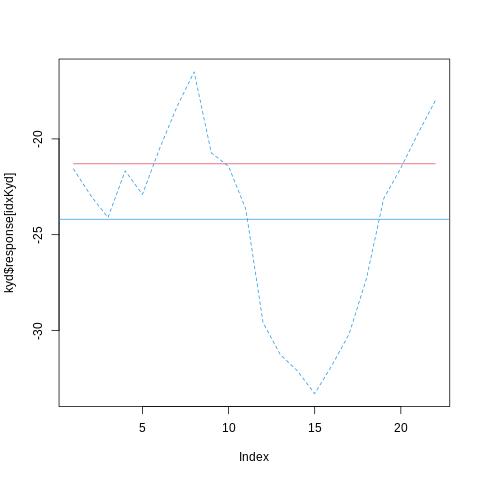

In [ ]:
%%R

# it must have been homogeneous throughout the half hour, right?
# feel free to change the time intervals and land covers, and explore!

  # get indices for minute fluxes during a given half-hour
  # half-hours in the range [1:354] work; [178] example is "UTC201908021830", or 12:30 local time on August 2, 2019
  idxKyd <- which(kyd$record == unique(kyd$record)[178])

  # let's check again that histogram
  hist(kyd$Wetlands[idxKyd] * 100, xlab = "Land cover in footprint [%]")

  # was there a temporal pattern throughout the half hour?
  plot(kyd$Wetlands[idxKyd], type = "l")

    # blue: how did the flux change in relation to that?
    plot(kyd$response[idxKyd], type = "l", lty = 2, col = 4)
    abline(a = mean(kyd$response[idxKyd], na.rm = TRUE), b = 0, col = 4)

    # red: to which extent was a standard 30-minute FLUXNET product able to capture that?
    lines(kyd$NEE_VUT_REF[idxKyd], col = 2)


##PART 2. Can high-frequency (HF) flux spatialization shed some light on what's going on here?

From the explorations above it appears that our mass balance control volume underlying eddy-covariance is by no means homogeneous and rather "leaky". Can flux spatialization help sort this out by runing fluxes backwards on the wind to their geographic sources and thus providing a separation of spatial and temporal controls?

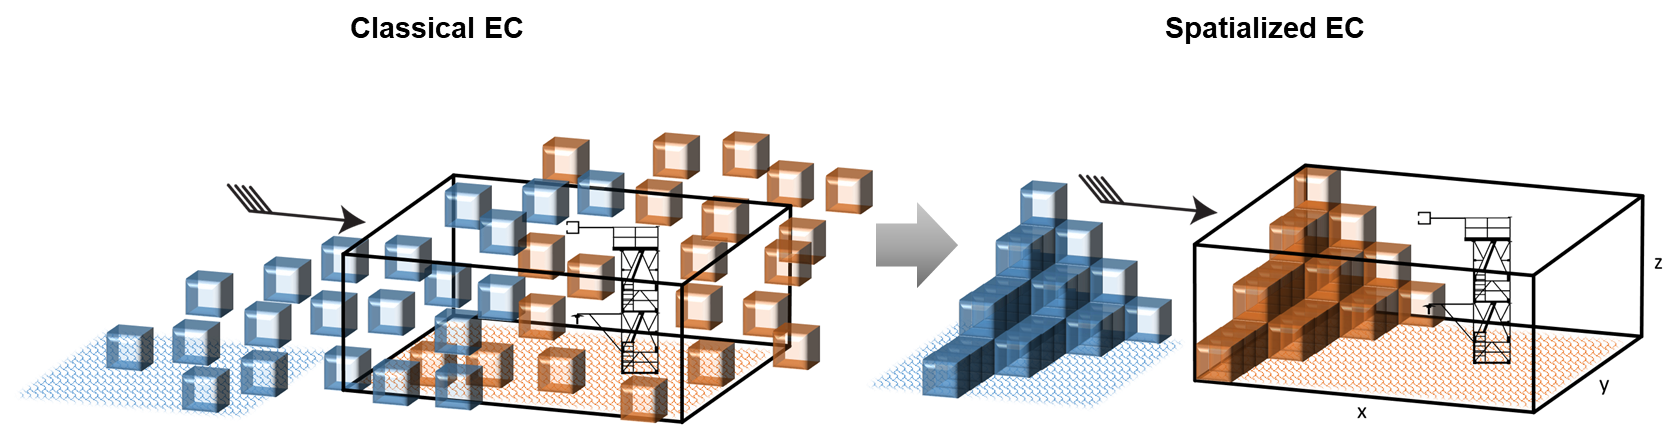

We will first grab the half-hourly HF flux spatialization maps from the Google drive folder. We want to ensure the times for the flux maps align with the FLUXNET weekly averaged product, so we will list the files and subset files based on if the time falls within our defined interval 2019-07-30 - 2019-08-06. We have to take into account the flux maps are provided in UTC time and the FLUXNET DP is in LST. We'll print the timestamps to ensure times have been subsetted properly.

In [ ]:
%%R

#Input file directory
DirInp <- ("/content/drive/Shareddrives/2024 Workshop - Remote Sensing and Fluxes Upscaling for Real-world Impact/Hands-on session/Topic2/Datasets/US-xUN_20190729-20190806/v20240704-02_FM2.2-9-days/QF0")

#Start and end dates to match with FLUXNET DP
dateBgn <- "2019-07-30"
dateEnd <- "2019-08-06"
timeDiffLst <- -6

#list files
gzFile <- list.files(path = DirInp, pattern = ".gz", recursive = TRUE, full.names = TRUE)

#Unzip the files
#Unzip file
lapply(gzFile, R.utils::gunzip)

  #List files to read in
FileInp <- list.files(path = DirInp, pattern = ".csv", recursive = TRUE, full.names = TRUE)

#Extract time
strTime <- stringr::str_extract(FileInp, "\\d{12}")
#Apply names to input files based on time
names(FileInp) <- strTime

#Parse date time from sting and convert to LST (-6 for US-xUN)
time <- lubridate::parse_date_time(strTime,  orders = "ymdHM") + lubridate::hours(timeDiffLst)

#Get indices from dates within our FLUXNET weekly averaged product
idxTime <- time %within% interval(ymd(dateBgn), ymd(dateEnd))
#Subset the input files to match the FLUXNET data
FileInpSub <- FileInp[idxTime]

#Check the times of the data
names(FileInpSub)

#Read .csv flux map files into a list
listData <- lapply(FileInpSub, read.csv, header = FALSE)


Now that we have read in the flux maps, we can bring them into a format we can use to perform our analysis. The flux maps have an extent of 6,020 m x 6,020 m  at 20 m resolution with US-xUN flux tower sonic anemometer in the center of the central pixel. We were lower left corner coordinates and all the crs information to convert the data to spatial raster.


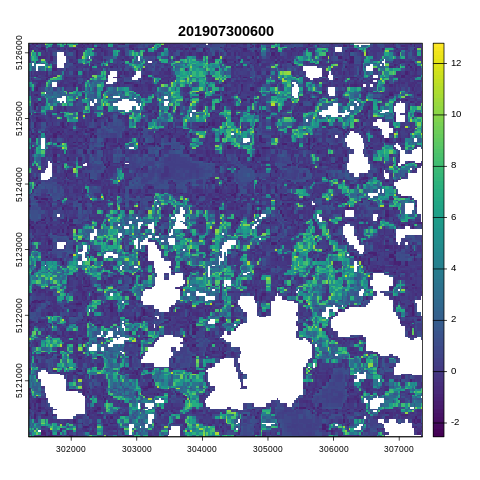

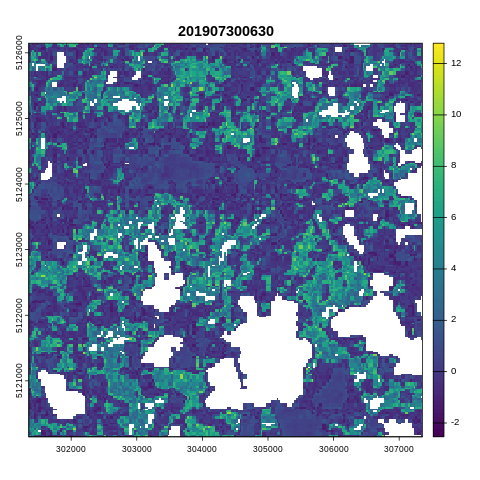

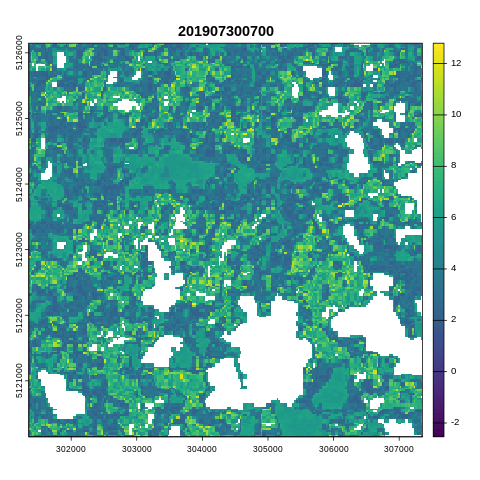

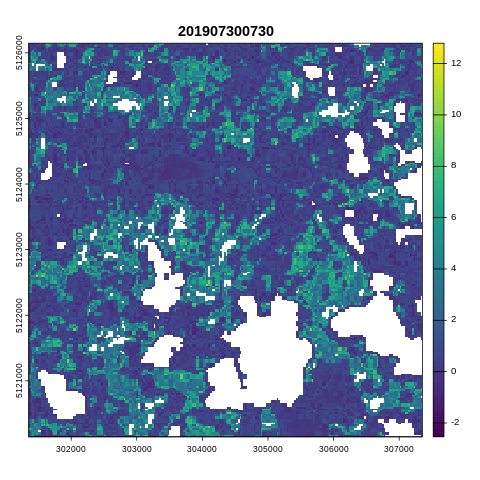

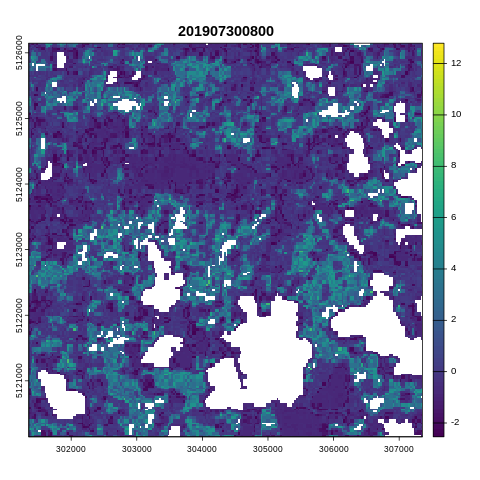

In [ ]:
%%R

#Coordinate information
reso <- 20
llx <- 301354
lly <- 5120147

#UTM coordinates from lower left corner
cord <- list(x = seq(from = llx, by = reso, length.out = 301), y = seq(from = lly, by = reso, length.out = 301))

#Convert the list of data.frames to a list of spatial rasters
listRastFlux <- sapply(listData, function(x){
  terra::rast( xmin = range(cord$x)[1], xmax = range(cord$x)[2], ymin = range(cord$y)[1], ymax = range(cord$y)[2],
                     nrows = dim(x)[1], ncols = dim(x)[2], vals = x,
                    crs="+proj=utm +zone=16 +datum=WGS84"
                    )
})

#Combine the list of rasters to equivalent of a raster stack
rastFlux <- terra::rast(listRastFlux)

#Plot animation
terra::animate(subset(rastFlux, 1:5))

Since, we want to make the comparison comparable to the timeseries analysis above where we used the weekly average NEE. We will combine our raster and take the mean across the whole week.

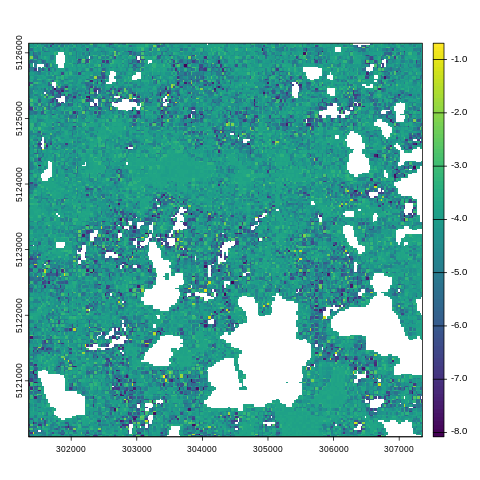

In [ ]:
%%R

#Apply the mean function across all the layer in the raster
rastFluxMean <- terra::app(rastFlux, mean)

#plot the mean NEE flux map
plot(rastFluxMean)

Let's align our flux map data with our remote sensing data products by reprojecting the data.

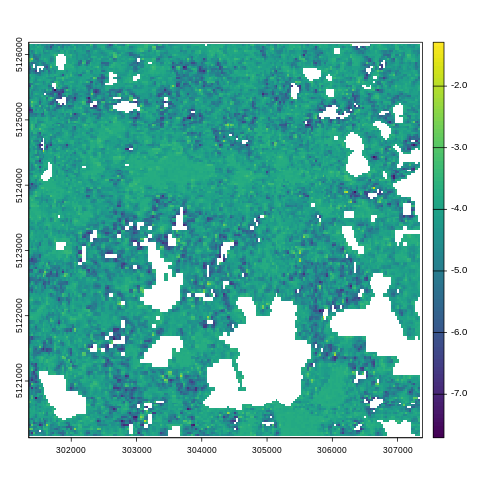

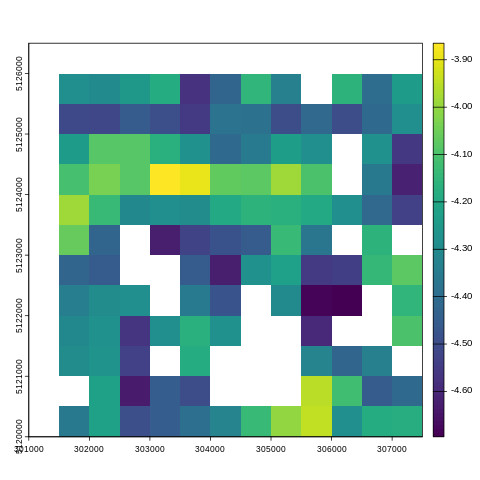

In [ ]:
%%R

#Reproject the raster to match remove sensing data
rastFluxLsat <- terra::project(rastFluxMean, rastLsat)
rastFluxMlai <- terra::project(rastFluxMean, rastMlai)

#Plot reprojected flux maps
plot(rastFluxLsat)
plot(rastFluxMlai)

The data are now projected in the same coordinate system with identical extent and resolution. Now let's take a look at the pixel-wise relatsionship between the spatialized EC and Landsat EVI and NIRV.

Whoaa - there seems to be a lot more going on than just greenness that controls NEE! Do different land covers play a role? What about temperature regulation of nighttime respiration? There also appear to be data-sparse regions for lower greeness values - should we consider more than a week of summertime data for the spatialized EC?

**Plenty motivation to get to the bottom of this at our next Upscaling Workshop!**

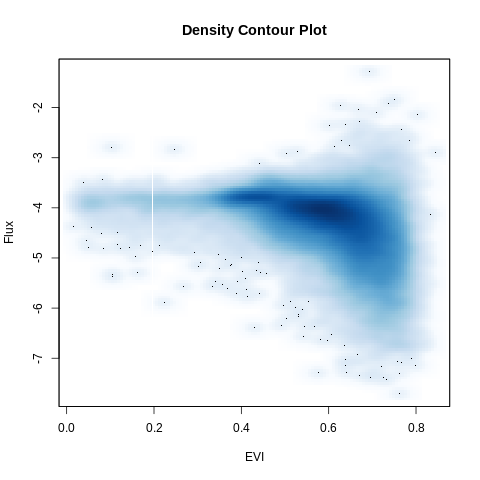

In [ ]:
%%R

#let's take a look at the pixel-wise relationship between EVI and NEE

# Extract values from the rasters
evi_values <- values(rastLsat$EVI)
flux_values <- values(rastFluxLsat)

# Remove any NA values
valid_indices <- !is.na(evi_values) & !is.na(flux_values)
evi_values <- evi_values[valid_indices]
flux_values <- flux_values[valid_indices]

# Create the smooth scatter plot
smoothScatter(evi_values, flux_values,
              main = "Density Contour Plot",
              xlab = "EVI",
              ylab = "Flux")


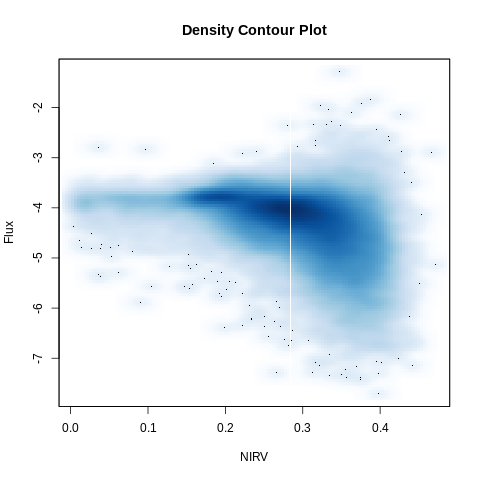

In [ ]:
%%R

#let's also take a look at the pixel-wise relationship between NIRV and NEE

# Extract values from the rasters
nirv_values <- values(rastLsat$NIRV)
flux_values <- values(rastFluxLsat)

# Remove any NA values
valid_indices <- !is.na(nirv_values) & !is.na(flux_values)
nirv_values <- nirv_values[valid_indices]
flux_values <- flux_values[valid_indices]

# Create the smooth scatter plot
smoothScatter(nirv_values, flux_values,
              main = "Density Contour Plot",
              xlab = "NIRV",
              ylab = "Flux")
